# Lung Cancer Prediction using Regression

Examine whether low income groups are at greater risk for being diagnosed and dying from cancer. If successful, our analysis will help the nonprofit with lobbying and fundraising.

Our goal is to demonstrate whether or not cancer incidence and mortality are correlated with socioeconomic status.

In [1]:
# data wrangling tools
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# datadotworld SDK
import datadotworld as ddw
% load_ext watermark

import time

UsageError: Line magic function `%` not found.


Cancer mortality and incidence data can be found at cancer.gov
For our analysis, we will using cancer statistics aggregated at the county level. In turn, we will be able to merge with data from the Census, also aggregated at the county level. While datasets with Census data have already been prepared and made available by the NIH, we will be merging the Census data ourselves.


In [49]:
mortdf = pd.read_csv(r"C:\Users\Karthik\Desktop\dataset\cancer prediction\cancer_mortality.csv")

incddf = pd.read_csv(r"C:\Users\Karthik\Desktop\dataset\cancer prediction\cancer_incidence.csv")

In [50]:
mortdf = mortdf[mortdf.fips.notnull()]
incddf = incddf[incddf.fips.notnull()]

mortdf['fips'] = mortdf.fips.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

incddf['fips'] = incddf.fips.apply(lambda x: str(int(x)))\
                            .astype(np.object_)\
                            .str.pad(5, 'left', '0')

# incddf.drop(incddf.columns[[0,3,4,7,8,9]].values, axis=1, inplace=True)
# mortdf.drop(mortdf.columns[[0,2,4,5,7,8,9,10]], axis=1, inplace=True)

# incddf.rename(columns={incddf.columns[1]:'Incidence_Rate',
#                        incddf.columns[2]:'Avg_Ann_Incidence'}, inplace=True)
# mortdf.rename(columns={mortdf.columns[1]:'Mortality_Rate',
#                        mortdf.columns[2]:'Avg_Ann_Deaths'}, inplace=True)
mortdf

,Unnamed: 0,county,fips,met_objective_of_45_5_1,age_adjusted_death_rate,lower_95_confidence_interval_for_death_rate,upper_95_confidence_interval_for_death_rate,average_deaths_per_year,recent_trend_2,recent_5_year_trend_2_in_death_rates,lower_95_confidence_interval_for_trend,upper_95_confidence_interval_for_trend
0,0,United States,00000,No,46,45.9,46.1,"157,376",falling,-2.4,-2.6,-2.2
1,1,"Perry County, Kentucky",21193,No,125.6,108.9,144.2,43,stable,-0.6,-2.7,1.6
2,2,"Powell County, Kentucky",21197,No,125.3,100.2,155.1,18,stable,1.7,0,3.4
3,3,"North Slope Borough, Alaska",02185,No,124.9,73,194.7,5,**,**,**,**
4,4,"Owsley County, Kentucky",21189,No,118.5,83.1,165.5,8,stable,2.2,-0.4,4.8
...,...,...,...,...,...,...,...,...,...,...,...,...
3136,3136,"Yakutat City and Borough, Alaska<sup>3</sup>",02282,*,*,*,*,*,**,**,**,**
3137,3137,"Yukon-Koyukuk Census Area, Alaska",02290,*,*,*,*,*,**,**,**,**
3138,3138,"Zapata County, Texas",48505,*,*,*,*,*,*,*,*,*
3139,3139,"Zavala County, Texas",48507,*,*,*,*,*,**,**,**,**


Now that we've acquired lung cancer incidence and mortality data, our goal is to include additional data that we can use to build a model. We want interesting variables which explain (are correlated with) incidence or mortality. A couple things to note:

To join with incidence and mortality, we need data that are indexed by US County.
We're looking for variables which explain (are correlated with) incidence and mortality.
We want interesting (meaningful and relevant) variables. For example:
Poverty,
Median Income,
Health insurance,
Employment
etc.

In [32]:
pov = ddw.load_dataset('uscensusbureau/acs-2015-5-e-poverty')

tables = []
for i in pov.tables:
    if len(i) == 2:
        tables.append(i)

# remove Puerto Rico
tables.remove('pr')

In [33]:
# Retrieve the Census poverty data from data.world
# start = time.time()

# a string - the poverty columns we want from the Census ACS 
cols = '`State`, `StateFIPS`, `CountyFIPS`, `AreaName`, `B17001_002`, `B17001_003`,'\
       '`B17001_017`'

# call the data for each state and concatenate
for i, state in enumerate(tables):
    if i == 0:
        povdf = ddw.query('uscensusbureau/acs-2015-5-e-poverty',
                  '''SELECT %s FROM `AK`
                     WHERE SummaryLevel=50''' % cols).dataframe 
    else:
        df = ddw.query('uscensusbureau/acs-2015-5-e-poverty',
                       '''SELECT %s FROM `%s`
                          WHERE SummaryLevel=50''' % (cols, state.upper())).dataframe
    
        povdf = pd.concat([povdf, df], ignore_index=True)

# end = time.time()

# print(end - start)


# Add leading zeros to the state and county FIPS codes
povdf['StateFIPS'] = povdf.StateFIPS.astype(np.object_)\
                                    .apply(lambda x: str(x))\
                                    .str.pad(2, 'left', '0')
povdf['CountyFIPS'] = povdf.CountyFIPS.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(3, 'left', '0')

povdf.rename(columns={'B17001_002':'All_Poverty', 'B17001_003':'M_Poverty', 'B17001_017':'F_Poverty'},
             inplace=True)

In [34]:
povdf.head()

,State,StateFIPS,CountyFIPS,AreaName,All_Poverty,M_Poverty,F_Poverty
0,AK,02,013,"Aleutians East Borough, Alaska",553,334,219
1,AK,02,016,"Aleutians West Census Area, Alaska",499,273,226
2,AK,02,020,"Anchorage Municipality, Alaska",23914,10698,13216
3,AK,02,050,"Bethel Census Area, Alaska",4364,2199,2165
4,AK,02,060,"Bristol Bay Borough, Alaska",69,33,36


In [35]:
cols = '`StateFIPS`, `CountyFIPS`,'\
       '`B19013_001`, `B19013A_001`, `B19013B_001`, `B19013C_001`, `B19013D_001`,'\
       '`B19013I_001`'

# start = time.time()

for i, state in enumerate(tables):
    if i == 0:
        incomedf = ddw.query('uscensusbureau/acs-2015-5-e-income',
                  '''SELECT %s FROM `AK`
                     WHERE SummaryLevel=50''' % cols).dataframe 
    else:
        df = ddw.query('uscensusbureau/acs-2015-5-e-income',
                       '''SELECT %s FROM `%s`
                          WHERE SummaryLevel=50''' % (cols, state.upper())).dataframe
        incomedf = pd.concat([incomedf, df], ignore_index=True)

#         end = time.time()

# print(end - start)

incomedf['StateFIPS'] = incomedf.StateFIPS.astype(np.object_)\
                                .apply(lambda x: str(x))\
                                .str.pad(2, 'left', '0')
incomedf['CountyFIPS'] = incomedf.CountyFIPS.astype(np.object_)\
                                 .apply(lambda x: str(x))\
                                 .str.pad(3, 'left', '0')

incomedf.rename(columns={'B19013_001':'Med_Income', 'B19013A_001':'Med_Income_White', 
                         'B19013B_001':'Med_Income_Black', 'B19013C_001':'Med_Income_Nat_Am',
                         'B19013D_001':'Med_Income_Asian', 'B19013I_001':'Hispanic'}, inplace=True)

In [36]:
incomedf

,StateFIPS,CountyFIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,Med_Income_Asian,Hispanic
0,02,013,61518.0,72639.0,31250.0,54750.0,62679.0,51250.0
1,02,016,84306.0,97321.0,93750.0,48750.0,81250.0,77500.0
2,02,020,78326.0,87235.0,50535.0,53935.0,63757.0,53926.0
3,02,050,51012.0,92647.0,73661.0,41594.0,110625.0,160114.0
4,02,060,79750.0,88000.0,NaN,63333.0,NaN,25625.0
...,...,...,...,...,...,...,...,...
3137,56,037,69022.0,69333.0,23535.0,NaN,NaN,53175.0
3138,56,039,75325.0,77651.0,NaN,NaN,NaN,41619.0
3139,56,041,56569.0,56532.0,NaN,NaN,NaN,40194.0
3140,56,043,47652.0,48110.0,NaN,NaN,NaN,29740.0


In [42]:
cols = '`StateFIPS`, `CountyFIPS`,'\
       '`B27001_004`, `B27001_005`, `B27001_007`, `B27001_008`,'\
       '`B27001_010`, `B27001_011`, `B27001_013`, `B27001_014`,'\
       '`B27001_016`, `B27001_017`, `B27001_019`, `B27001_020`,'\
       '`B27001_022`, `B27001_023`, `B27001_025`, `B27001_026`,'\
       '`B27001_028`, `B27001_029`, `B27001_032`, `B27001_033`,'\
       '`B27001_035`, `B27001_036`, `B27001_038`, `B27001_039`,'\
       '`B27001_041`, `B27001_042`, `B27001_044`, `B27001_045`,'\
       '`B27001_047`, `B27001_048`, `B27001_050`, `B27001_051`,'\
       '`B27001_053`, `B27001_054`, `B27001_056`, `B27001_057`'
# male <= 029   

# start = time.time()

for i, state in enumerate(tables):
    if i == 0:
        hinsdf = ddw.query('uscensusbureau/acs-2015-5-e-healthinsurance',
                  '''SELECT %s FROM `AK`
                     WHERE SummaryLevel=50''' % cols).dataframe 
   
    else:
        df = ddw.query('uscensusbureau/acs-2015-5-e-healthinsurance',
                       '''SELECT %s FROM `%s`
                          WHERE SummaryLevel=50''' % (cols, state.upper())).dataframe
        hinsdf = pd.concat([hinsdf, df], ignore_index=True)

# end = time.time()
# print(end - start)

hinsdf['StateFIPS'] = hinsdf.StateFIPS.astype(np.object_)\
                                      .apply(lambda x: str(x))\
                                      .str.pad(2, 'left', '0')
hinsdf['CountyFIPS'] = hinsdf.CountyFIPS.astype(np.object_)\
                                        .apply(lambda x: str(x))\
                                        .str.pad(3, 'left', '0')

In [43]:
hinsdf

,StateFIPS,CountyFIPS,B27001_004,B27001_005,B27001_007,B27001_008,B27001_010,B27001_011,B27001_013,B27001_014,...,B27001_044,B27001_045,B27001_047,B27001_048,B27001_050,B27001_051,B27001_053,B27001_054,B27001_056,B27001_057
0,02,013,57,20,91,62,51,212,90,246,...,68,55,168,134,59,117,48,9,25,0
1,02,016,111,28,279,61,260,102,335,219,...,231,99,266,76,169,116,72,12,17,0
2,02,020,12404,1513,21747,2957,12011,3967,17188,5650,...,15569,3050,16525,3482,15011,2310,8106,252,4829,29
3,02,050,1002,145,1951,204,460,511,666,597,...,736,224,625,281,501,251,372,6,197,0
4,02,060,32,4,71,16,39,13,36,30,...,53,9,63,13,49,14,13,0,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,56,037,2015,146,3776,258,1835,437,2672,1010,...,2242,455,2326,459,2393,290,1212,0,783,0
3138,56,039,578,0,1319,183,476,110,1617,959,...,1288,325,1302,241,1380,107,769,40,454,0
3139,56,041,910,86,2175,162,630,292,986,268,...,1004,373,1122,248,1277,141,633,0,389,0
3140,56,043,278,16,635,12,81,151,367,87,...,314,129,426,181,477,104,429,0,366,0


In [44]:
# columns representing males' health insurance statistics
males = ['`B27001_004`', '`B27001_005`', '`B27001_007`', '`B27001_008`',
           '`B27001_010`', '`B27001_011`', '`B27001_013`', '`B27001_014`',
           '`B27001_016`', '`B27001_017`', '`B27001_019`', '`B27001_020`',
           '`B27001_022`', '`B27001_023`', '`B27001_025`', '`B27001_026`',
           '`B27001_028`', '`B27001_029`']

# females' health insurance statistics
females = ['`B27001_032`', '`B27001_033`', '`B27001_035`', '`B27001_036`', 
           '`B27001_038`', '`B27001_039`', '`B27001_041`', '`B27001_042`', 
           '`B27001_044`', '`B27001_045`', '`B27001_047`', '`B27001_048`', 
           '`B27001_050`', '`B27001_051`', '`B27001_053`', '`B27001_054`', 
           '`B27001_056`', '`B27001_057`']

# separate the "with" and "without" health insurance columns
males_with = []
males_without = []
females_with = []
females_without = []

# strip the backticks
for i, j in enumerate(males):
    if i % 2 == 0:
        males_with.append(j.replace('`', ''))
    else:
        males_without.append(j.replace('`', ''))
        
for i, j in enumerate(females):
    if i % 2 == 0:
        females_with.append(j.replace('`', ''))
    else:
        females_without.append(j.replace('`', ''))

# Create features that sum all the individual age group
clist = [males_with, males_without, females_with, females_without]
newcols = ['M_With', 'M_Without', 'F_With', 'F_Without'] 

for col in newcols:
    hinsdf[col] = 0

for i in males_with:
    hinsdf['M_With'] += hinsdf[i]  
for i in males_without:
    hinsdf['M_Without'] += hinsdf[i]
for i in females_with:
    hinsdf['F_With'] += hinsdf[i]
for i in females_without:
    hinsdf['F_Without'] += hinsdf[i]

hinsdf['All_With'] = hinsdf.M_With + hinsdf.F_With
hinsdf['All_Without'] = hinsdf.M_Without + hinsdf.F_Without

# Remove all the individual age group variables
# but, save them as a df called hinsdf_extra (just in case)
hinsdf_extra = df.loc[:, df.columns[df.columns.str.contains('B27001')].values]
hinsdf.drop(df.columns[df.columns.str.contains('B27001')].values, axis=1, inplace=True)

In [51]:
incddf['FIPS'] = incddf['fips']
mortdf['FIPS'] = mortdf['fips']

### Merge DataFrames    
We're going to merge on the FIPS column. It's a 5-digit code. The first 2 digits are the 2-digit FIPS state code. The third, fourth, and fifth are the 3-digit FIPS county code.   
1. First, let's create a "FIPS" in each dataframe by concatenating the state and county codes.   
2. Then, let's check to make sure that they properly match up.

In [52]:
dfs = [povdf, incomedf, hinsdf, incddf, mortdf]

In [53]:
# create FIPS features
for df in [povdf, incomedf, hinsdf]:
    df['FIPS'] = df.StateFIPS + df.CountyFIPS
    df.drop(['StateFIPS', 'CountyFIPS'], axis=1, inplace=True)

In [54]:
# use the pandas isin() method to see the intersections of FIPS features
# across dataframes
[[i, ii, sum(pd.Series(j.FIPS.unique()).isin(dfs[ii].FIPS))] 
    for i, j in enumerate(dfs) for ii in range(len(dfs))]

[[0, 0, 3142],
 [0, 1, 3142],
 [0, 2, 3142],
 [0, 3, 3134],
 [0, 4, 3134],
 [1, 0, 3142],
 [1, 1, 3142],
 [1, 2, 3142],
 [1, 3, 3134],
 [1, 4, 3134],
 [2, 0, 3142],
 [2, 1, 3142],
 [2, 2, 3142],
 [2, 3, 3134],
 [2, 4, 3134],
 [3, 0, 3134],
 [3, 1, 3134],
 [3, 2, 3134],
 [3, 3, 3141],
 [3, 4, 3141],
 [4, 0, 3134],
 [4, 1, 3134],
 [4, 2, 3134],
 [4, 3, 3141],
 [4, 4, 3141]]

In [55]:
# look at the number of unique FIPS values per dataframe
for i in dfs:
    print(len(i.FIPS.unique()))

3142
3142
3142
3141
3141


In [56]:
# check to see if all the FIPS values are 5 digits in length
dfs = [povdf, incomedf, hinsdf, incddf, mortdf] # our 5 dataframes to merge
for i, j in enumerate(dfs):
    lens = []
    for fips in j.FIPS.values:
        lens.append(len(fips))
    print(pd.Series(lens).value_counts(), '\n', '-'*10)  

5    3142
dtype: int64 
 ----------
5    3142
dtype: int64 
 ----------
5    3142
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------
5    3141
dtype: int64 
 ----------


In [57]:
# It looks like the FIPS column in each dataframe is formatted well and they match up. Let's join them together into one large dataframe.
for i, j in enumerate(dfs):
    if i == 0:
        fulldf = j.copy()
    else:
        fulldf = fulldf.merge(j, how='inner', on='FIPS')

##  Exploratory Analysis

In [58]:
fulldf.shape

(3134, 41)

In [59]:
fulldf.head()

,State,AreaName,All_Poverty,M_Poverty,F_Poverty,FIPS,Med_Income,Med_Income_White,Med_Income_Black,Med_Income_Nat_Am,...,fips_y,met_objective_of_45_5_1,age_adjusted_death_rate,lower_95_confidence_interval_for_death_rate,upper_95_confidence_interval_for_death_rate,average_deaths_per_year,recent_trend_2,recent_5_year_trend_2_in_death_rates,lower_95_confidence_interval_for_trend,upper_95_confidence_interval_for_trend
0,AK,"Aleutians East Borough, Alaska",553,334,219,02013,61518.0,72639.0,31250.0,54750.0,...,02013,*,*,*,*,*,**,**,**,**
1,AK,"Aleutians West Census Area, Alaska",499,273,226,02016,84306.0,97321.0,93750.0,48750.0,...,02016,*,*,*,*,*,**,**,**,**
2,AK,"Anchorage Municipality, Alaska",23914,10698,13216,02020,78326.0,87235.0,50535.0,53935.0,...,02020,No,47.3,42.9,52,96,falling,-1.2,-1.8,-0.6
3,AK,"Bethel Census Area, Alaska",4364,2199,2165,02050,51012.0,92647.0,73661.0,41594.0,...,02050,No,58.3,36.6,86.8,5,**,**,**,**
4,AK,"Bristol Bay Borough, Alaska",69,33,36,02060,79750.0,88000.0,NaN,63333.0,...,02060,*,*,*,*,*,**,**,**,**


In [60]:
# check for null values
for col in fulldf.columns:
    print((col, sum(fulldf[col].isnull())))

('State', 0)
('AreaName', 0)
('All_Poverty', 0)
('M_Poverty', 0)
('F_Poverty', 0)
('FIPS', 0)
('Med_Income', 1)
('Med_Income_White', 2)
('Med_Income_Black', 1210)
('Med_Income_Nat_Am', 1660)
('Med_Income_Asian', 1757)
('Hispanic', 681)
('M_With', 0)
('M_Without', 0)
('F_With', 0)
('F_Without', 0)
('All_With', 0)
('All_Without', 0)
('Unnamed: 0_x', 0)
('county_x', 0)
('fips_x', 0)
('age_adjusted_incidence_rate_e_cases_per_100_000', 0)
('lower_95_confidence_interval', 0)
('upper_95_confidence_interval', 0)
('average_annual_count', 0)
('recent_trend', 0)
('recent_5_year_trend_in_incidence_rates', 0)
('lower_95_confidence_interval_2', 0)
('upper_95_confidence_interval_2', 0)
('Unnamed: 0_y', 0)
('county_y', 0)
('fips_y', 0)
('met_objective_of_45_5_1', 0)
('age_adjusted_death_rate', 0)
('lower_95_confidence_interval_for_death_rate', 0)
('upper_95_confidence_interval_for_death_rate', 0)
('average_deaths_per_year', 0)
('recent_trend_2', 0)
('recent_5_year_trend_2_in_death_rates', 0)
('lower_9

In [61]:
# The median income by ethnicity data is incomplete. Let's get rid of all but the broad "Med_Income" feature.

fulldf.drop(['Med_Income_White', 'Med_Income_Black', 'Med_Income_Nat_Am',
             'Med_Income_Asian', 'Hispanic'], axis=1, inplace=True)

In [63]:
def get_types(col_name):
    ts = (pd.Series([type(i) for i in fulldf[col_name]]).value_counts())
    print("%s\n" % feature, ts, "\n", "-"*30)

for feature in fulldf.columns:
    get_types(feature)

State
 <class 'str'>    3134
dtype: int64 
 ------------------------------
AreaName
 <class 'str'>    3134
dtype: int64 
 ------------------------------
All_Poverty
 <class 'int'>    3134
dtype: int64 
 ------------------------------
M_Poverty
 <class 'int'>    3134
dtype: int64 
 ------------------------------
F_Poverty
 <class 'int'>    3134
dtype: int64 
 ------------------------------
FIPS
 <class 'str'>    3134
dtype: int64 
 ------------------------------
Med_Income
 <class 'float'>    3134
dtype: int64 
 ------------------------------
M_With
 <class 'int'>    3134
dtype: int64 
 ------------------------------
M_Without
 <class 'int'>    3134
dtype: int64 
 ------------------------------
F_With
 <class 'int'>    3134
dtype: int64 
 ------------------------------
F_Without
 <class 'int'>    3134
dtype: int64 
 ------------------------------
All_With
 <class 'int'>    3134
dtype: int64 
 ------------------------------
All_Without
 <class 'int'>    3134
dtype: int64 
 --------------

In [67]:
# renaming columns

fulldf.rename(columns={"age_adjusted_death_rate":"Mortality_Rate", "age_adjusted_incidence_rate_e_cases_per_100_000":"Incidence_Rate"}, inplace=True)

In [68]:
# Mortality_Rate
# This script isolates values that fail to convert to numeric
def f(column):
    types = []
    for _, j in enumerate(column):
        try:
            pd.to_numeric(j)
            
        except:
            types.append(j)
    print(pd.Series(types).value_counts())

f(fulldf.Mortality_Rate)

*    325
dtype: int64


We can see 325 of the Mortality_Rate samples contain an asterisk. We can see from the documentation that the asterisk represents a suppression of the data in instances when fewer then 16 annual cases were reported.

Is the fact that fewer than 16 cases were reported due to poor reporting? In that case we may want to delete those observations. Or, we may want to try to impute the values.
Do we think these data points are accurate? In that case we may want to change "*" to zero, or a number smaller than 16.
If the observations are actually valid and we remove them, then we add bias to the model.
If the observations are noise, then we should either delete them or impute them.
The key here is to make in informed decision and to prepare an explanation and defense of why you made that decision.
Let's explore the data to inform our decision.

In [70]:
# which states are associated with the "*"s?
fulldf.loc[fulldf.Incidence_Rate=='*', 'State'].value_counts()

TX    47
NE    31
SD    24
ND    22
CO    16
MT    15
ID    10
UT    10
AK     8
NM     6
GA     4
OK     4
OR     3
VA     2
WY     2
CA     2
MS     1
HI     1
MI     1
WA     1
MO     1
Name: State, dtype: int64

min 9.2 max 125.6


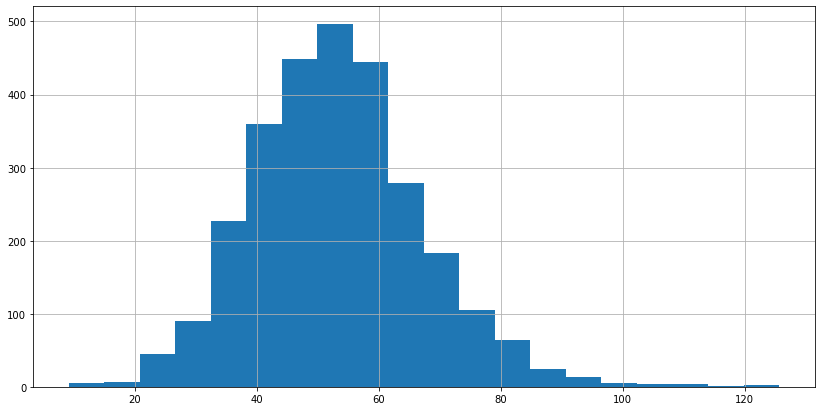

In [71]:
# Histogram to see how exceptional a low rate of mortality is
mhist = pd.to_numeric(fulldf.Mortality_Rate[fulldf.Mortality_Rate != '*'])
print("min", mhist.min(), "max", mhist.max())
mhist.hist(figsize=(14,7), bins=20);

I feel like if we can show that the counties with asterisks are all low population, then we should treat them as valid and replace them with a low value (eg, 8). If they're not all low-population, then that may suggest that it's noise and we should remove those observations.

Let's go ahead and bring in some population by county data.
I went to data.world and entered "population by county" into the search field. I found this dataset, which meets our needs perfectly:

In [73]:
populationdf = ddw.query('nrippner/us-population-estimates-2015',
                         '''SELECT `POPESTIMATE2015`, `STATE`, `COUNTY`
                            FROM `CO-EST2015-alldata`''').dataframe

In [74]:
populationdf.shape

(3193, 3)

In [75]:
state = populationdf.STATE.apply(lambda x: str(x))\
                          .str.pad(2, 'left', '0')
county = populationdf.COUNTY.apply(lambda x: str(x))\
                            .str.pad(3, 'left', '0')

populationdf['FIPS'] = state + county

populationdf.head()

,POPESTIMATE2015,STATE,COUNTY,FIPS
0,4858979,1,0,01000
1,55347,1,1,01001
2,203709,1,3,01003
3,26489,1,5,01005
4,22583,1,7,01007


In [76]:
print(sum(pd.Series(fulldf.FIPS.unique()).isin(populationdf.FIPS)), 'matches out of')
print("%d unique values" % len(fulldf.FIPS.unique()))

3134 matches out of
3134 unique values


In [77]:
fulldf = fulldf.merge(populationdf[['FIPS', 'POPESTIMATE2015']], on='FIPS', how='inner')

In [78]:
# Find median as reference point
fulldf.POPESTIMATE2015.median()
print("median, mean population:         %.1f, %.1f" % (fulldf.POPESTIMATE2015.median(),
                                         fulldf.POPESTIMATE2015.mean()))
print("median, mean population '*':      %.1f,   %.1f" % (fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].median(),
                                            fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].mean()))
print("median, mean population not '*': %.1f, %.1f" % (fulldf.POPESTIMATE2015[fulldf.Mortality_Rate != '*'].median(),
                                                fulldf.POPESTIMATE2015[fulldf.Mortality_Rate != '*'].mean()))

median, mean population:         25763.5, 102521.9
median, mean population '*':      2985.0,   3917.8
median, mean population not '*': 31183.0, 113930.3


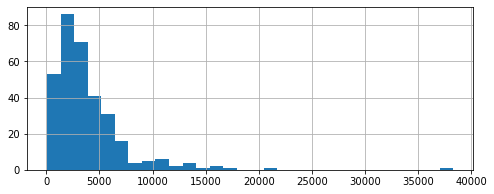

In [79]:
fulldf.POPESTIMATE2015[fulldf.Mortality_Rate == '*'].hist(figsize=(8,3), bins=30);

Yes, the counties with asterisks are definitely lower in population than those without. But, I'm still not convinced that we should trust that they actually had no lung cancer mortalities. I suspect that the low population counties may be less likely to keep and report good data. Let's examine further.

In [80]:
population_levels = [0, 1000, 5000, 10000, 15000, 20000, 50000, 100000, 500000, 10**6]
for i in range(1,len(population_levels)):
    print("population:", "%d-%d" % (population_levels[i-1], population_levels[i]),"median mort. rate:",
                                    fulldf.Mortality_Rate[(fulldf.Mortality_Rate != '*') &
                                                          (population_levels[i-1] < fulldf.POPESTIMATE2015) &
                                                          (fulldf.POPESTIMATE2015 < population_levels[i])].median())

population: 0-1000 median mort. rate: nan
population: 1000-5000 median mort. rate: 57.4
population: 5000-10000 median mort. rate: 52.1
population: 10000-15000 median mort. rate: 54.95
population: 15000-20000 median mort. rate: 56.3
population: 20000-50000 median mort. rate: 54.25
population: 50000-100000 median mort. rate: 53.5
population: 100000-500000 median mort. rate: 49.3
population: 500000-1000000 median mort. rate: 42.9


Lung cancer mortality rate appears to be higher in lower population counties. That realization makes me more skeptical of the validity of our missing values. The documentation from the data source states that the records marked by an asterisk indicate fewer than 16 reported cases of mortality from lung cancer. The records with asterisks tend to be very low population. Yet, we've learned that we'd expect them to have higher, not lower, mortality rates as compared with higher population counties (in general).

In [81]:
# Before making a decision, lets see how many low-population counties actually did report.

print("Not '*'")
for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate != '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 


Not '*'
# records between 0-1000 population 0
# records between 1000-5000 population 59
# records between 5000-10000 population 337
# records between 10000-15000 population 322
# records between 15000-20000 population 259
# records between 20000-50000 population 852
# records between 50000-100000 population 388
# records between 100000-500000 population 455
# records between 500000-1000000 population 92


In [82]:
# a closer look at number of records for very low-population counties (< 5000)
print("not '*'")
population_levels = [2500, 3000, 3500, 4000, 4500, 5000]

for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate != '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 

print("'*'") 
for i in range(1, len(population_levels)):
    print("# records between","%d-%d population" % (population_levels[i-1], population_levels[i]), 
                                      fulldf[(fulldf.Mortality_Rate == '*') &
                                             (fulldf.POPESTIMATE2015 <= population_levels[i]) &
                                             (fulldf.POPESTIMATE2015 > population_levels[i-1])].shape[0]) 

not '*'
# records between 2500-3000 population 2
# records between 3000-3500 population 5
# records between 3500-4000 population 14
# records between 4000-4500 population 19
# records between 4500-5000 population 17
'*'
# records between 2500-3000 population 33
# records between 3000-3500 population 28
# records between 3500-4000 population 23
# records between 4000-4500 population 20
# records between 4500-5000 population 10


I think we have plenty of information now to use to decide what to do with the observations where mortality rate is missing.
The fact is, that because mortality rate is our target variable, we probably could have skipped all this investigation and opted to simply remove the missing records. However, I think this was a worthwhile exercise to walk through. In any case, I'm inclined to remove the rows with missing mortality rate values entirely. Here's why:

Low-population counties are already well-represented in the data (there are plenty of non-null observations).
It seems redundant (and a source of unnecessary noise) to impute missing values in the outcome variable in this case.
I think it's safe to treat the null values as if they were randomly drawn (they may not be entirely random, but it seems unlikely to me that we're losing much information at this time by removing them).
Given that lower populations tend (when they do report) to have higher mortality rates, I suspect that it's misleading to state that the asterisks represent counties which reported "fewer than 16" cases of mortality. Instead, I believe that the asterisks more likely represent counties which failed to collect and/or report mortality data. Note that we are dealing with normalized mortality rates -- per capita (100,000). I'm confident that those records should be omitted.

In [83]:
fulldf = fulldf[fulldf.Mortality_Rate != '*']

In [84]:
# Med_Income
fulldf['Med_Income'] = pd.to_numeric(fulldf.Med_Income)  # That was easy!

In [85]:
# Incidence_Rate
# Let's use this script to see which values fail to convert to numeric:
values = []
for _, j in enumerate(fulldf.Incidence_Rate):
    try:
        pd.to_numeric(j)
    except:
        values.append(j)
        
pd.Series(values).value_counts()[:10]

_         151
__         12
*           5
71.1 #      2
73.6 #      2
68.2 #      2
73.4 #      1
70.8 #      1
75.6 #      1
84 #        1
dtype: int64

We already decided that we're going to omit any records where Mortality_Rate is missing (asterisk).
We see that | and || also indicate missing values due to legislative reasons, and no data from Nevada, respectively.
The hash sign, we're told, means "Data do not include cases diagnosed in other states for those states in which the data exchange agreement specifically prohibits the release of data to third parties."

How should we proceed? Well, mortality rate is our target variable. Also, it's arguably a more interesting variable and it's already clean and homogenous. So, if we remove any additional rows, we're losing good mortality rate data. So, I feel strongly that we should not omit any rows in order to fix Incidence_Rate. For now, let's leave incidence rate alone. If we want to include it in our explanatory variables, we can consider imputing the missing values. Else, if we want to create a model with it as the outcome, we can deal with that separately.


Avg_Ann_Incidence and Avg_Ann_Deaths
are closely related with the Incidence_Rate and Mortality_Rate variables, respectively. It's safe to assume that we're more interested in these values normalized by population (rates rather than raw values). So, I think they're redundant -- we already have information about mortality and incidence rates included, as well as a population, included in the model.

In [87]:
# create dummy variables for "Recent Trend"

# rename 'Recent Trend' to remove the space
fulldf.rename(columns={'recent_trend':'RecentTrend'}, inplace=True)

# change all the missing values to the mode ('stable')
fulldf.replace({'RecentTrend' : {'*':'stable'}}, inplace=True)

# function to do boolean check and return 1 or 0
def f(x, term):
    if x == term:
        return 1
    else:
        return 0

# create new features using the apply method with the 'f' function we defined above
fulldf['Rising'] = fulldf.RecentTrend.apply(lambda x: f(x, term='rising'))
fulldf['Falling'] = fulldf.RecentTrend.apply(lambda x: f(x, term='falling'))

# Note that of the 3 levels of RecentTrend, we only created dummies for rising and falling
# We will be incuding constant in our model (dummy variable trap

In [88]:
fulldf['RecentTrend'].value_counts()

stable     2410
falling     197
_           151
rising       39
__           12
Name: RecentTrend, dtype: int64

In [89]:
y = pd.to_numeric(fulldf.Mortality_Rate).values
X = fulldf.loc[:,['All_Poverty', 'M_Poverty', 'F_Poverty', 'Med_Income',
            'M_With', 'M_Without', 'F_With', 'F_Without', 'All_With',
            'All_Without', 'Incidence_Rate', 'Falling', 'Rising',
            'POPESTIMATE2015']]

In [90]:
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Falling,Rising,POPESTIMATE2015
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,61.5,0,0,298695
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,62.7,0,0,17946
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,58.1,0,0,99631
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,35.1,0,0,32756
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,64.9,0,0,58059


In this case we should probably convert our numeric data to per capita. Our target variable, mortality rate, is measured per 100,000 population. By normalizing each variable by 100,000 population, we can more easily assess how they correlate with each other. In case we want to account for the influence of population in our model, we can also retain the population feature.

If we recall, the Incidence_Rate feature contains some values (eg, '*', '||', & '|') that we need to deal with before we can convert into numeric format. Let's do that now. Fortunately, pandas makes this quite easy.

The "errors='coerce'" argument to the pd.to_numeric method, tells pandas to replace any value that can't be converted to a float with 'nan'.

In [91]:
X['Incidence_Rate'] = pd.to_numeric(X.Incidence_Rate, errors='coerce')

In [92]:
X['Incidence_Rate'] = X.Incidence_Rate.fillna(X.Incidence_Rate.median())
print(sum(X.Incidence_Rate.isnull()))

0


In [93]:
# converting to per capita

for col in ['All_Poverty', 'M_Poverty', 'F_Poverty', 'M_With',
            'M_Without', 'F_With', 'F_Without', 'All_With', 'All_Without']:
       
    X[col + "_PC"] = X[col] / X.POPESTIMATE2015 * 10**5


In [94]:
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,...,POPESTIMATE2015,All_Poverty_PC,M_Poverty_PC,F_Poverty_PC,M_With_PC,M_Without_PC,F_With_PC,F_Without_PC,All_With_PC,All_Without_PC
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,...,298695,8006.160130,3581.579872,4424.580257,40424.848089,7782.185842,40986.959942,7162.155376,81411.808032,14944.341218
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,...,17946,24317.396634,12253.426948,12063.969687,35640.254096,15089.713585,36927.449014,9885.211189,72567.703109,24974.924774
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,...,99631,7780.710823,3536.048017,4244.662806,40755.387379,6982.766408,40358.924431,5341.710913,81114.311811,12324.477321
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,...,32756,6441.567957,3495.542801,2946.025156,41943.460740,7427.646843,41464.159238,6756.014165,83407.619978,14183.661009
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,...,58059,9573.020548,4471.313664,5101.706884,38565.941542,11083.552938,37320.656573,9357.722317,75886.598116,20441.275254


C:\Users\Karthik\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


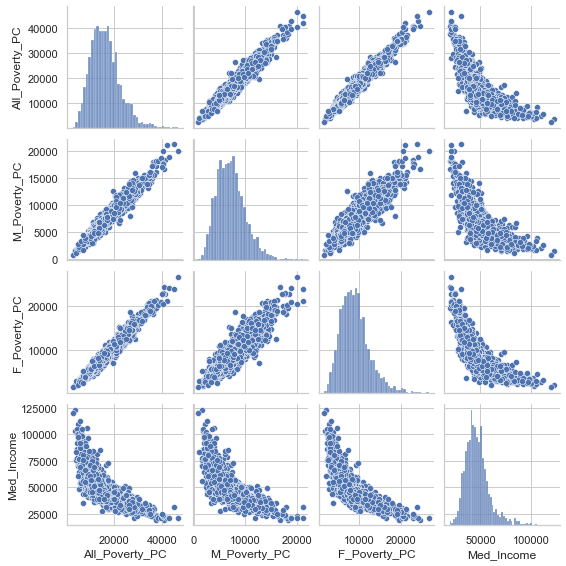

In [95]:
# scatterplots (hat tip Sebastian Raschka from his book "Python Machine Learning")
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']], size=2)
plt.show()

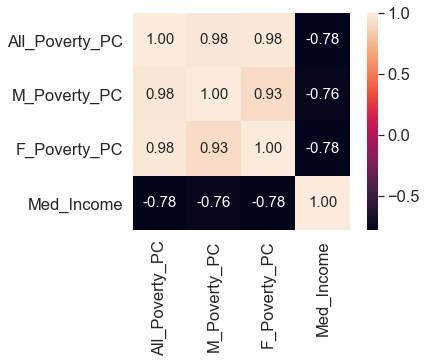

In [96]:
cols = ['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']
cm = np.corrcoef(X[['All_Poverty_PC', 'M_Poverty_PC', 'F_Poverty_PC', 'Med_Income']].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

We see that All_Poverty_PC, F_Poverty_PC and M_Poverty_PC look pretty much perfectly correlated. We don't want redundant features. So let's drop M_Poverty_PC and F_Poverty_PC and keep only All_Poverty_PC to represent poverty information in our model.

After repeating this process with our health insurance variables, it became clear that the gender-specific features are redundant. After removing them, we're left with these data:

In [97]:
X.drop(['M_Poverty_PC', 'F_Poverty_PC'], axis=1, inplace=True)

In [98]:
X.drop(['M_With_PC', 'F_With_PC'], axis=1, inplace=True)
X.drop(['M_Without_PC', 'F_Without_PC'], axis=1, inplace=True)
X.head()

,All_Poverty,M_Poverty,F_Poverty,Med_Income,M_With,M_Without,F_With,F_Without,All_With,All_Without,Incidence_Rate,Falling,Rising,POPESTIMATE2015,All_Poverty_PC,All_With_PC,All_Without_PC
2,23914,10698,13216,78326.0,120747,23245,122426,21393,243173,44638,61.5,0,0,298695,8006.160130,81411.808032,14944.341218
3,4364,2199,2165,51012.0,6396,2708,6627,1774,13023,4482,62.7,0,0,17946,24317.396634,72567.703109,24974.924774
7,7752,3523,4229,71068.0,40605,6957,40210,5322,80815,12279,58.1,0,0,99631,7780.710823,81114.311811,12324.477321
9,2110,1145,965,85746.0,13739,2433,13582,2213,27321,4646,35.1,0,0,32756,6441.567957,83407.619978,14183.661009
10,5558,2596,2962,63684.0,22391,6435,21668,5433,44059,11868,64.9,0,0,58059,9573.020548,75886.598116,20441.275254


C:\Users\Karthik\anaconda3\lib\site-packages\seaborn\axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


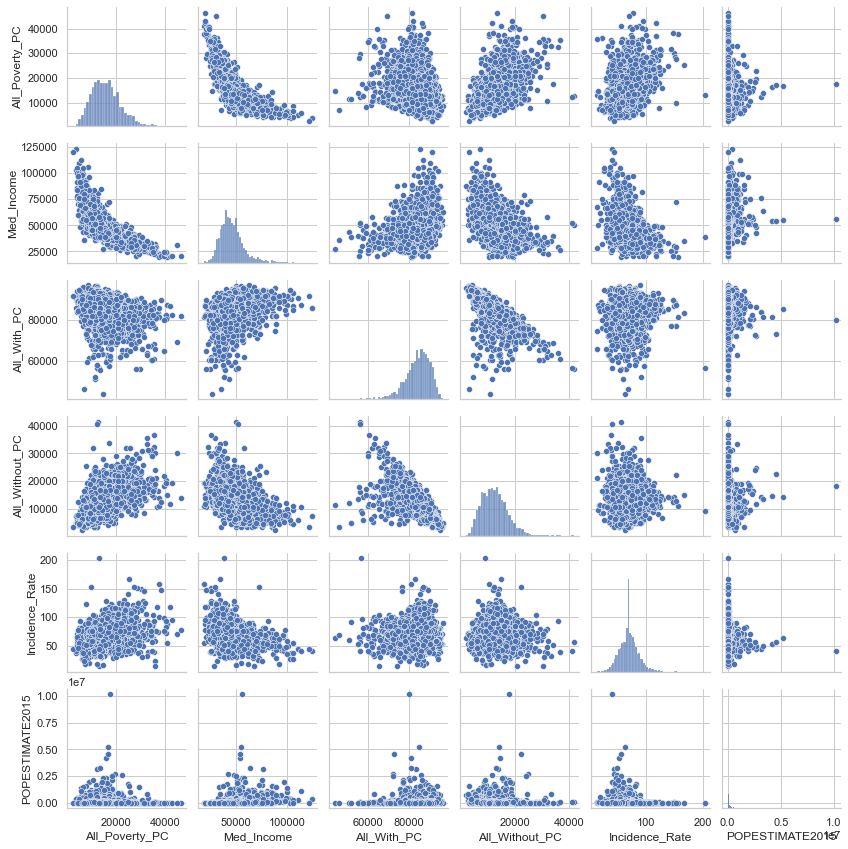

In [99]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
                'Incidence_Rate', 'POPESTIMATE2015']
sns.set(style='whitegrid', context='notebook')
sns.pairplot(X[cols], size=2)
plt.show()

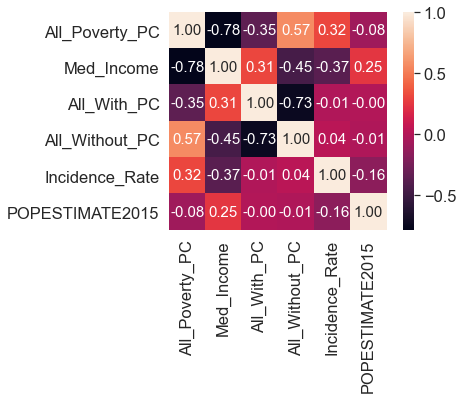

In [100]:
cm = np.corrcoef(X[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':15},
                 yticklabels=cols, xticklabels=cols)
plt.show()

There are a couple pairs of fairly strongly correlated features: (All_Poverty_PC & Med_Income) and (All_With_PC & All_Without_PC). We'll keep them in mind as we observe how they work in the linear regression.

## Linear Regression model

In [101]:
cols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC',  'All_Without_PC',
        'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty',
        'All_With', 'All_Without']

In [102]:
# add constant (coloumn vector of all 1s)
X = X[cols]
X['Constant'] = 1
X.reset_index(drop=True, inplace=True)

In [103]:
# Fit linear regression model
lr = sm.OLS(y, X, hasconst=True)
result = lr.fit()

In [104]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     718.0
Date:                Thu, 28 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:34:39   Log-Likelihood:                -9523.1
No. Observations:                2809   AIC:                         1.907e+04
Df Residuals:                    2797   BIC:                         1.914e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
All_Poverty_PC   9.517e-05   4.12e-05      2.308      0.021    1.43e-05       0.000
Med_Income         -0.0001   2.04e-05     -4.982      0.000      -0.000   -6.17e-05
All_With_PC      9.094e-06   3.33e-05      0.273      0.785   -5.61e-05    7.43e-05
All_Without_PC      0.0002   5.04e-05      4.310      0.000       0.000       0.000
Incidence_Rate      0.6517      0.009     73.756      0.000       0.634       0.669
POPESTIMATE2015 -4.224e-05   2.69e-05     -1.573      0.116   -9.49e-05    1.04e-05
Falling             1.2490      0.562      2.224      0.026       0.148       2.350
Rising             -1.0811      1.163     -0.929      0.353      -3.362       1.200
All_Poverty      -2.81e-05    1.3e-05     -2.167      0.030   -5.35e-05   -2.67e-06
All_With         4.428e-05   2.77e-05      1.600      0.110   -9.99e-06    9.86e-05
All_Without      5.714e-05   3.24e-05      1.762      0.078   -6.44e-06       0.000
Constant            7.2748      3.482      2.089      0.037       0.448      14.102
==============================================================================
Omnibus:                      306.600   Durbin-Watson:                   1.703
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.415
Skew:                          -0.204   Prob(JB):                         0.00
Kurtosis:                       7.447   Cond. No.                     1.23e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After fitting an ordinary least squares model with the ['All_Poverty_PC', 'Med_Income', 'All_With_PC', All_Without_PC', 'Incidence_Rate', 'POPESTIMATE2015', 'Falling', 'Rising', 'All_Poverty', 'All_With', 'All_Without'] regressed on the Mortality_Rate target variable, we have a pretty well-performing model, as evidenced by the Adjusted R^2 (738).

Let's treat this as our baseline, and apply model diagnostics and feature selection to try to improve it.

We will attempt to account for multicollinearity, heteroscedsticity of residuals, and normality of distributions of residuals.

Multicollinearity
Let's apply variance inflation factors to assess for multicollinearity. VIFs, by performing an independent variable on the design matrix comprising all the other independent variables, allows us to assess the degree to which that independent variable is orthogonal the others. Larger VIFs indicate multicollinearity.
(!)note: VIF values exceeding 10 are commonly interpreted as "high" in multicollinearity. However, this threshold is arbitrary, and it may make sense to select a different threshold in many cases.

In [105]:
pd.DataFrame([[var, variance_inflation_factor(X.values, X.columns.get_loc(var))] for var in X.columns],
                   index=range(X.shape[1]), columns=['Variable', 'VIF'])

,Variable,VIF
0,All_Poverty_PC,3.454206
1,Med_Income,3.490674
2,All_With_PC,2.433937
3,All_Without_PC,3.180459
4,Incidence_Rate,1.225081
5,POPESTIMATE2015,4692.901021
6,Falling,1.116247
7,Rising,1.005324
8,All_Poverty,30.052522
9,All_With,3342.491590


In [106]:
# After iteratively removing the feature associated with the largest VIF and then recalculating VIFs, we result in these independent variables:

vcols = ['All_Poverty_PC', 'Med_Income', 'All_With_PC', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'Rising', 'Constant']

In [107]:
Xvcols = X[vcols].reset_index(drop=True)
pd.DataFrame([[var, variance_inflation_factor(Xvcols.values, Xvcols.columns.get_loc(var))] for var in vcols],
                   index=range(len(vcols)), columns=['Variable', 'VIF'])

,Variable,VIF
0,All_Poverty_PC,3.174942
1,Med_Income,2.798807
2,All_With_PC,2.217165
3,All_Without_PC,2.923831
4,Incidence_Rate,1.207559
5,Falling,1.035371
6,Rising,1.004835
7,Constant,606.236305


Interestingly, All_Without (men and women without health insurance), versus the same per capita (All_Without_PC) don't indicate high multicollinearity. I'm not sure what to make of that. In any case, I'm opting to remove All_Without from the model because I believe that it's more or less a proxy for population.

Let's recompute a linear regression on the reduced set of independent variables.

In [108]:
vcols = ['All_Poverty_PC', 'Med_Income', 'All_Without_PC',
       'Incidence_Rate', 'Falling', 'POPESTIMATE2015', 'Constant']
Xvcols = X[vcols].reset_index(drop=True)
lr = sm.OLS(y, Xvcols, hasconst=True)
result = lr.fit()

In [109]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     1314.
Date:                Thu, 28 Oct 2021   Prob (F-statistic):               0.00
Time:                        19:37:42   Log-Likelihood:                -9526.6
No. Observations:                2809   AIC:                         1.907e+04
Df Residuals:                    2802   BIC:                         1.911e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
All_Poverty_PC   8.805e-05   3.97e-05      2.219      0.027    1.03e-05       0.000
Med_Income      -9.367e-05   1.89e-05     -4.954      0.000      -0.000   -5.66e-05
All_Without_PC      0.0002    3.5e-05      6.147      0.000       0.000       0.000
Incidence_Rate      0.6538      0.009     74.362      0.000       0.637       0.671
Falling             1.2889      0.560      2.303      0.021       0.192       2.386
POPESTIMATE2015 -1.773e-06    4.3e-07     -4.123      0.000   -2.62e-06    -9.3e-07
Constant            7.6227      1.602      4.758      0.000       4.481      10.764
==============================================================================
Omnibus:                      305.716   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2327.137
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                       7.441   Cond. No.                     4.31e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.31e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

I'm satisfied with how this model looks. Specifically: 1) VIFs indicate that it's not afflicted by multicollinearity, 2) all the parameters are statistically significant (P>|t|), & 3) all the parameters logically make sense (eg, oriented in directions that logically make sense).

Let's move on and take a look at residuals to assess for normality and heteroscedasticity.

Are residuals normally distributed?

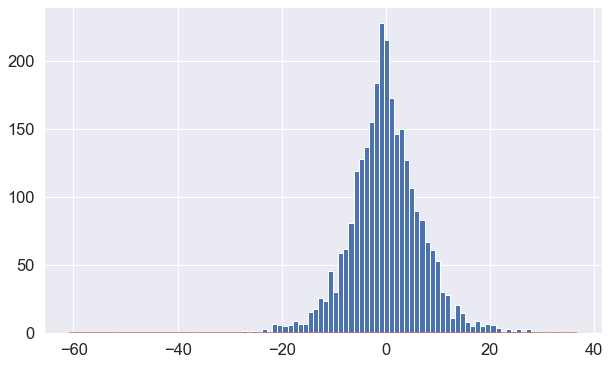

In [111]:
# histogram superimposed by normal curve
plt.figure(figsize=(10,6))
import scipy.stats as stats
mu = np.mean(result.resid)
sigma = np.std(result.resid)
pdf = stats.norm.pdf(sorted(result.resid), mu, sigma)
plt.hist(result.resid, bins=100)
plt.plot(sorted(result.resid), pdf, color='r', linewidth=2)
plt.show()

The distribution of the residuals does not adhere perfectly to a normal distribution (skew=0, excess kurtosis=0). There is a small number of outliers to the left, the tails appear slightly fatter than, and the distribution has somewhat larger kurtosis than the normal distribution.

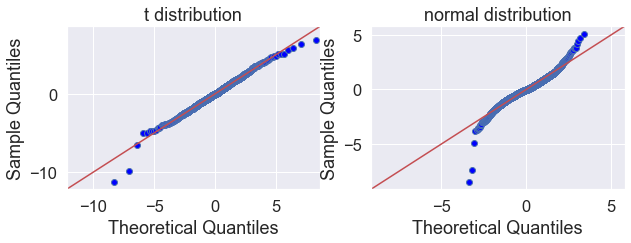

In [112]:
# QQplot
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,3))
sm.qqplot(result.resid, stats.t, fit=True, line='45', ax = ax1)
ax1.set_title("t distribution")
sm.qqplot(result.resid, stats.norm, fit=True, line='45', ax=ax2)
ax2.set_title("normal distribution")
plt.show()

The qqplots confirm that the residuals adhere more closely to the t- than normal distribution (fatter tails). A few prominent outliers are visible at the lower extreme.

All-in-all, despite these imperfections, I consider the distribution of residuals to be adequate. However, we should investigate the nature of the more extreme outliers. We also may want to try to add additional information to the model (new variable(s)), in light of the the model's tendency to overestimate low values and underestimate high values.

C:\Users\Karthik\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


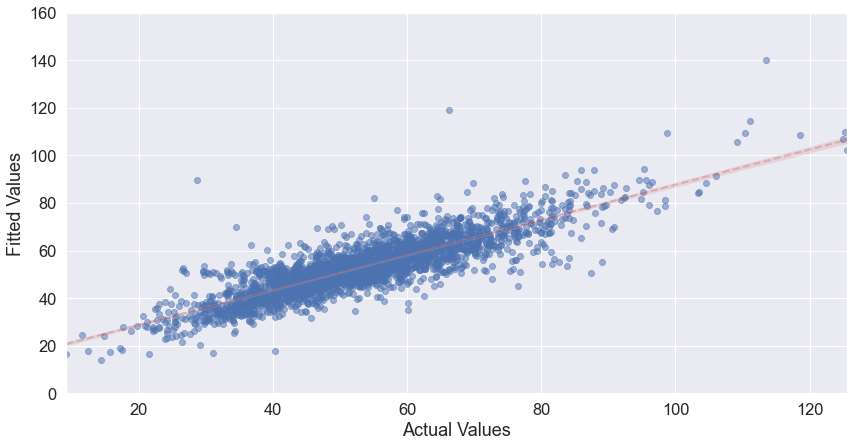

Pearson R:  (0.8589643646814895, 0.0)


In [113]:
# Heteroscedasticity

# plot predicted vs actual
plt.figure(figsize=(14,7))
sns.regplot(y, result.fittedvalues, line_kws={'color':'r', 'alpha':0.3, 
                                              'linestyle':'--', 'linewidth':2}, 
            scatter_kws={'alpha':0.5})
plt.ylim(0,160)
plt.xlabel('Actual Values')
plt.ylabel('Fitted Values')
plt.show()
print("Pearson R: ", stats.pearsonr(result.fittedvalues, y))

Consistent with our reported R^2 value, we now visualize the strong correlation between actual and predicted values.

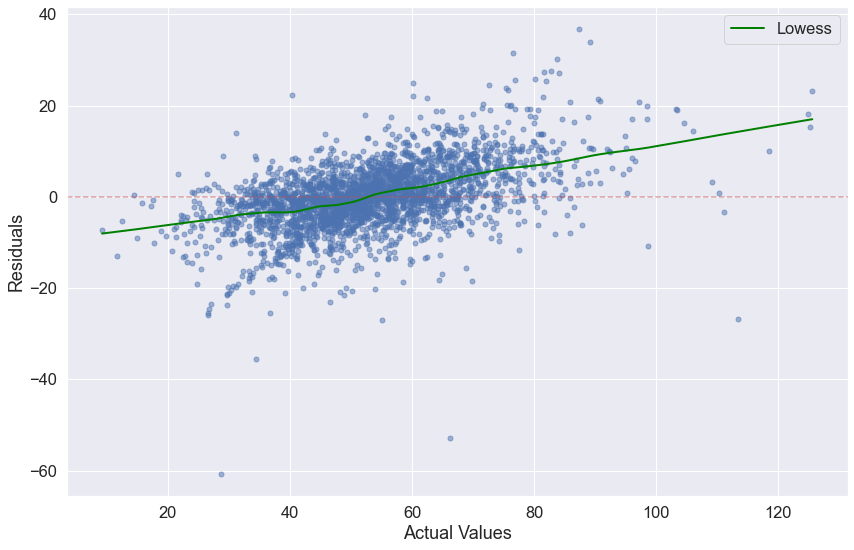

Pearson R: (0.5120353700745239, 1.368622116875006e-187)


In [114]:
# plot actual values versus residuals
from statsmodels.nonparametric.smoothers_lowess import lowess
ys = lowess(result.resid.values, y, frac=0.2)
ys = pd.DataFrame(ys, index=range(len(ys)), columns=['a', 'b'])
ys = ys.sort_values(by='a')

fig, ax = plt.subplots(figsize=(14,9))
plt.scatter(y, result.resid, alpha=0.5, s=25)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Residuals")

plt.plot(ys.a, ys.b, c='green', linewidth=2, label="Lowess")
plt.legend()
plt.show()
print("Pearson R:", stats.pearsonr(y, result.resid))

This chart suggests that the model tends to somewhat overshoot lower values, and undershoot higher ones.

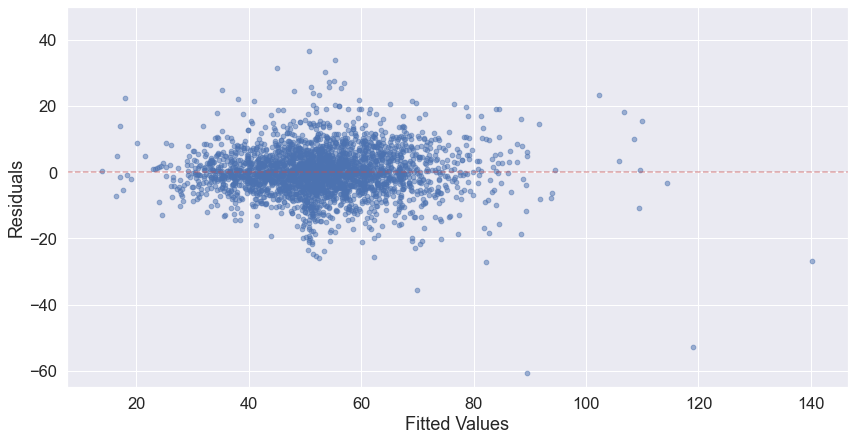

In [115]:
# plot actual values versus residuals
plt.figure(figsize=(14,7))
plt.scatter(y=result.resid, x=result.fittedvalues, alpha=0.5, s=22)
plt.axhline(y=0, color='r', linestyle="--", alpha=0.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.ylim(-65, 50)
plt.show()

The plot of residuals versus fitted values shows that the residuals are fairly symmetric relative to the fitted values.

Model Diagnostics Summary

Multicollinearity does not appear to be present.
Parameters are statistically significant.
The residuals adhere more closely to a t- than a normal distribution -- larger excess kurtosis and fatter tails.
The fitted values tend to err in the negative direction (overestimate) actual values toward the lower extreme of the range, and the inverse for values toward the high end of the range.
The adjusted R^2 is 0.74, meaning that the model accounts for 74% of the total observed variance in the target.
improvements to the model should focus on accounting for outliers and, if possible, adding additional information to the model.